<a href="https://colab.research.google.com/github/DrAlexSanz/Resnet/blob/master/Resnet_with_signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook solves the classification of the tests dataset with a resnet. The Resnet is a CNN (in this case) with shortcircuits. This tries to tackle the problem of vanishing gradients in VERY deep NN. I'll detail my topology later on.

In [33]:
import numpy as np
import keras
import tensorflow as tf

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [18, 12]
import h5py

from PIL import Image

from keras import layers, optimizers
from keras.layers import Input, Dense, Conv2D, Activation, ZeroPadding2D, BatchNormalization, Flatten, Add
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D

from keras.models import Model, Sequential

from keras.preprocessing import image

from keras.initializers import glorot_uniform

from keras.utils import layer_utils, plot_model

from keras.callbacks import History, ModelCheckpoint

keras.backend.set_image_data_format('channels_last')

%matplotlib inline

print("Everything imported correctly")

Everything imported correctly


In [23]:
#First remove the folder and everything it contains.

!rm -rf Resnet

#Now I clone the repository and everything works.

! git clone https://github.com/DrAlexSanz/Resnet.git

Cloning into 'Resnet'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (10/10), done.


In [24]:
#Now read data

with h5py.File("Resnet/test_signs.h5") as test:
  test_x_1 = np.array(test["test_set_x"][:]) # your train set features
  test_y_1 = np.array(test["test_set_y"][:]) # your train set labels
  classes = np.array(test["list_classes"][:]) # the list of classes

with h5py.File("Resnet/train_signs.h5") as train:
  train_x_1 = np.array(train["train_set_x"][:]) # train set features
  train_y_1 = np.array(train["train_set_y"][:]) # train set labels

print("Everything loaded and imported")

Everything loaded and imported


In [0]:
#Normalize

train_x = train_x_1/255
test_x = test_x_1/255

train_y = train_y_1
test_y = test_y_1

In [26]:
print("X train shape is: " + str(train_x.shape))
print("Y train shape is: " + str(train_y.shape))
print("X test shape is: " + str(test_x.shape))
print("Y test shape is: " + str(test_y.shape))

X train shape is: (1080, 64, 64, 3)
Y train shape is: (1080,)
X test shape is: (120, 64, 64, 3)
Y test shape is: (120,)


y = 0


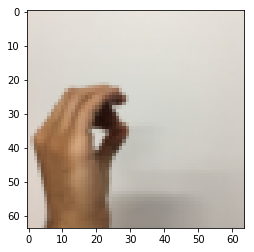

In [27]:
plt.imshow(train_x_1[45])
print("y = " + str(train_y_1[45]))

So this is the loading as in the case of the signs CNN in TF. Nothing new here. The novelty is the topology of the network. I'll explain with a picture.

![ID Block]("Resnet/idblock3_kiank.png")


Ok, the visualization doesn't work so I'll plot the model later on.

There is the main path, which is the normal (C)NN and the shortcircuit. The main path is made of a basic block (ID block) which is shortcircuited. At the end of the ID block, the shortcircuit is added to the output of this ID block, but only if the dimensions are the same. This is repeated a number of times. If I want to add the shortcircuit and the dimensions have changed along the main path I need to apply a CONV2D with the appropriate parameters in the shortcircuit path. I will do this in this case, but it is only one of the options.

The structure, in this case, is the following:

MAIN PATH

First component 

1.   CONV2D with $F_1$ filters of shape (1, 1), stride of (1, 1) and padding VALID (dims will change). The name is CONV_NAME_BASE + "2a"
2.   BatchNorm block, to normalize the channels axis. The name is BN_NAME_BASE + "2a"
3.   RELU. No name

Second component



1.   CONV2D with $F_2$ filters of shape ($f$, $f$), stride of (1, 1) and padding SAME. The name is CONV_NAME_BASE + "2b"
2.   BatchNorm block, to normalize the channels axis. The name is BN_NAME_BASE + "2b"
3.   RELU. No name

Third component



1.   CONV2D with $F_3$ filters of shape (1, 1), stride of (1, 1) and padding VALID. The name is CONV_NAME_BASE + "2c"
2.   BatchNorm block, to normalize the channels axis. The name is BN_NAME_BASE + "2c"
3.   NO ACTIVATION

Last step, add the output of the third component to the output of the shortcircuit block and then pass it through a RELU. If I add it later, the shortcircuit is not capturing any nonlinearity!!!

The shortcircuit path has a CONV2D + BatchNorm. IF I don't change the dimensions this is not necessary.




In [0]:
def ID_Block(X, f, filters, stage, block):
    """
    Implementation of the ID block described in the previous cell

    Inputs:
    X is the batch of pictures (m, height, width, channels)
    f is the shape of the filters for the second block of main path
    filters is the list with the 3 numbers of filters for each block [f1, f2, f3]
    stage is the position of the block, for naming
    block is a string to name the layers

    Output:
    X is the ID block created. Shape is (height, width, channels)

    """


    #Define names
    conv_name_base = "Res" + str(stage) + block + "_branch"
    BN_name_base = "BN" + str(stage) + block + "_branch"
    
    # Separate filters
    
    F1, F2, F3 = filters
    
    #Save the input for the shortcut
    
    X_shortcut = X
    
    # Al lío
    # First component of main path
    
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1, 1), padding = "valid", name = conv_name_base + "2a", kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = BN_name_base + "2a")(X) #BN for the channels only
    X = Activation("relu")(X)
    
    #Second component of main path
        
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = "same", name = conv_name_base + "2b", kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = BN_name_base + "2b")(X) #BN for the channels only
    X = Activation("relu")(X)
    
    # Third component of main path
        
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = "valid", name = conv_name_base + "2c", kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = BN_name_base + "2c")(X) #BN for the channels only
    #NO RELU NOW!!!
    
    #Add the shortcut and RELU
    
    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)
    
    return X
    
    



In [35]:
#To test

tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_in = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = ID_Block(A_in, f = 2, filters = [2, 4, 6], stage = 1, block = "a")
    test.run(tf.global_variables_initializer())
    test_out = test.run([A], feed_dict = {A_in: X, keras.backend.learning_phase(): 0})
    print("Out is: ", test_out[0][1][1][0])

Out is:  [0.9482299 0.        1.1610144 2.747859  0.        1.36677  ]


So the previous block works. That is reassuring. Also:

#The error AttributeError __Enter__ comes when I forget the () in with tf.Session() as...

Always the same story.

Now I have to implement the Convolutional block. It's the same block as before but before adding the shortcut I pass it through a CONV2D block and BN

In [0]:
def CONV_Block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the CONV block described in the previous cell

    Inputs:
    X is the batch of pictures (m, height, width, channels)
    f is the shape of the filters for the second block of main path
    filters is the list with the 3 numbers of filters for each block [f1, f2, f3]
    stage is the position of the block, for naming
    block is a string to name the layers
    s is the stride

    Output:
    X is the ID block created. Shape is (height, width, channels)

    """


    #Define names
    conv_name_base = "Res" + str(stage) + block + "_branch"
    BN_name_base = "BN" + str(stage) + block + "_branch"
    
    # Separate filters
    
    F1, F2, F3 = filters
    
    #Save the input for the shortcut
    
    X_shortcut = X
    
    # Al lío
    # First component of main path
    
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (s, s), padding = "valid", name = conv_name_base + "2a", kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = BN_name_base + "2a")(X) #BN for the channels only
    X = Activation("relu")(X)
    
    #Second component of main path
        
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = "same", name = conv_name_base + "2b", kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = BN_name_base + "2b")(X) #BN for the channels only
    X = Activation("relu")(X)
    
    # Third component of main path
        
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = "valid", name = conv_name_base + "2c", kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = BN_name_base + "2c")(X) #BN for the channels only
    #NO RELU NOW!!!
    
    #Shortcut path
    
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s, s), padding = "valid", name = conv_name_base + "1", kernel_initializer = glorot_uniform(seed = 0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = BN_name_base + "1")(X_shortcut)
    
    #Add the shortcut and RELU
    
    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)
    
    return X
    
    



In [38]:
#To test

tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(1)
    A_in = tf.placeholder("float", [3, 4, 4, 6])
    X = np.random.randn(3, 4, 4, 6)
    A = CONV_Block(A_in, f = 2, filters = [2, 4, 6], stage = 1, block = "a")
    test.run(tf.global_variables_initializer())
    test_out = test.run([A], feed_dict = {A_in: X, keras.backend.learning_phase(): 0})
    print("Out is: ", test_out[0][1][1][0])

Out is:  [0.09018461 1.2348977  0.46822017 0.0367176  0.         0.655166  ]
